<a href="https://colab.research.google.com/github/Prisze/AAI-521/blob/main/Group11_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
!pip install vit-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 13.6 MB/s eta 0:00:00


# Training and Testing Helper

In [ ]:
import torch
import torch.nn.functional as F

def eval(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            # Get the inputs
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = net(images)

            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Get the predicted class indices
            predicted = torch.argmax(probabilities, dim=1)

            # Get the true class indices from one-hot encoded labels
            true_labels = torch.argmax(labels, dim=1)

            # Compare predicted with ground truth
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()
            # breakpoint()

    return correct / total


In [ ]:
import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(net, criterion, optimizer, trainloader, testloader, epochs=10, gradient_clipping=None, scheduler=None, quiet=False, output_file='vit'):
  start_time = time.time()
  accuracies = []
  max_accuracy = 0
  for epoch in range(epochs):
      current_lr = optimizer.param_groups[0]['lr']
      if not quiet:
        print(f'Epoch {epoch + 1}/{epochs} - Current Learning Rate: {current_lr:.6f}')
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # Get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          # Backward pass and optimize
          loss.backward()
          if gradient_clipping is not None:
            torch.nn.utils.clip_grad_norm_(net.parameters(), gradient_clipping)
          optimizer.step()

          # Print statistics
          running_loss += loss.item()

          report_frequency = len(trainloader) // 5
          if i % report_frequency == 0:    # Print every 200 mini-batches
              if not quiet:
                print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] loss: {running_loss / report_frequency:.3f}')
              running_loss = 0.0

      # Handle learning rate scheduler, if needed
      if scheduler is not None:
        scheduler.step()

      # Run evaluation on test set and train set
      train_acc = eval(net, trainloader)
      test_acc = eval(net, testloader)
      accuracies.append((train_acc, test_acc))
      if not quiet:
          print(f'Accuracy of the network on the test images: {100 * test_acc:.2f}%')

      if test_acc > max_accuracy:
          max_accuracy = test_acc
          # Save the trained model
          PATH = f'./{output_file}_{float(test_acc):.2f}.pth'
          torch.save(net.state_dict(), PATH)


  end_time = time.time()
  if not quiet:
    print(f'Finished Training, took {(end_time - start_time):.2f} seconds')

  final_acc = eval(net, testloader)
  return accuracies

# Prepare Dataset

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomErasing, RandomHorizontalFlip
from sklearn.model_selection import KFold

# Load and preprocess the CSV file
data = pd.read_csv('ckextended.csv')
data['pixels'] = data['pixels'].apply(lambda x: list(map(int, x.strip('[]').split(' '))))

data

,emotion,pixels,Usage
0,6,"[36, 39, 35, 25, 19, 11, 8, 7, 3, 13, 15, 9, 2...",Training
1,6,"[88, 74, 19, 4, 5, 5, 3, 12, 8, 21, 15, 21, 15...",Training
2,6,"[9, 2, 4, 7, 1, 1, 1, 0, 7, 29, 49, 76, 115, 1...",Training
3,6,"[104, 106, 108, 104, 95, 50, 60, 61, 58, 83, 1...",Training
4,6,"[68, 72, 67, 67, 6, 2, 1, 1, 1, 1, 1, 14, 24, ...",Training
...,...,...,...
915,5,"[87, 86, 88, 92, 92, 127, 231, 248, 251, 253, ...",PrivateTest
916,5,"[21, 24, 26, 28, 27, 28, 30, 8, 0, 0, 0, 0, 0,...",PrivateTest
917,5,"[76, 40, 31, 38, 28, 34, 38, 36, 41, 36, 46, 3...",PrivateTest
918,5,"[114, 87, 16, 29, 17, 25, 30, 34, 37, 35, 45, ...",PrivateTest


In [ ]:

# Define the custom dataset
class FaceEmotionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['pixels']
        label = self.dataframe.iloc[idx]['emotion']
        image = np.array(image, dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image, mode='L')
        if self.transform:
            image = self.transform(image)
        label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=8).float()
        return image, label

# Split the data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=452)

# Split the data for cross validation
kf_idx = list(KFold(n_splits=5, shuffle=True, random_state=452).split(data))

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    RandomHorizontalFlip(p=0.5),
    RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3), inplace=False),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
])

# Create DataLoader for train and test sets
train_dataset = FaceEmotionDataset(train_df, transform=transform_train)
test_dataset = FaceEmotionDataset(test_df, transform=transform_test)

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

kf_loaders = [
    (DataLoader(FaceEmotionDataset(data.iloc[train_idx], transform=transform_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    DataLoader(FaceEmotionDataset(data.iloc[test_idx], transform=transform_test), batch_size=64, shuffle=False, num_workers=2))
    for (train_idx, test_idx) in kf_idx
]

# Visualization

In [ ]:
EMOTION_MAPPING = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

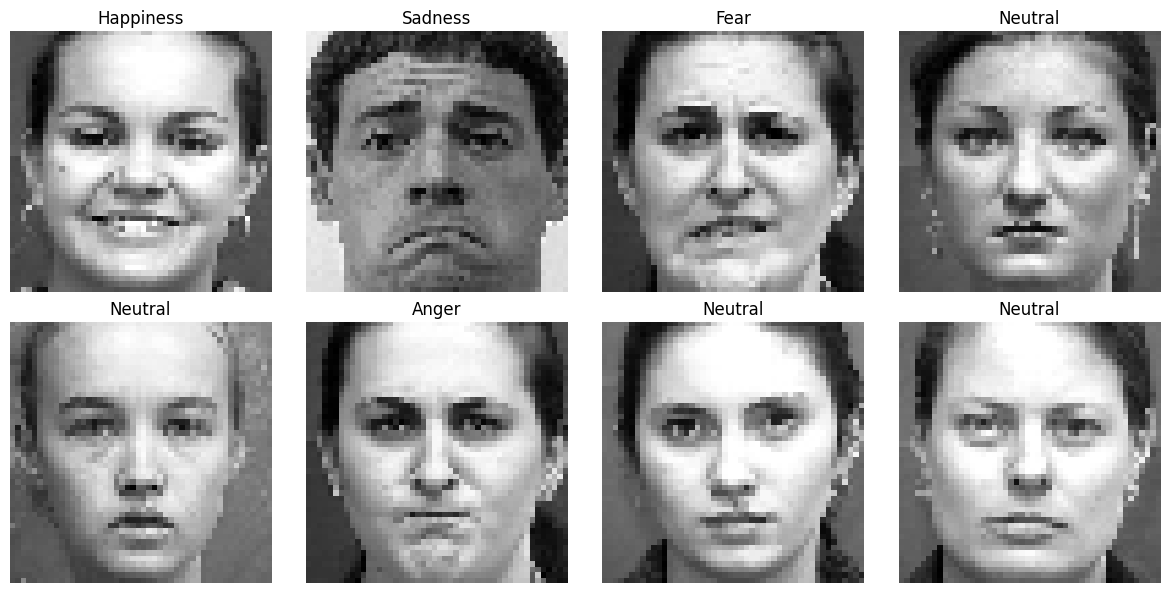

In [ ]:
from matplotlib import pyplot as plt
import random

random_indices = random.sample(range(len(data)), 8)

images = [np.array(row).reshape(48, 48) for row in data["pixels"][random_indices]]
emotions = [EMOTION_MAPPING[emotion] for emotion in data["emotion"][random_indices]]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, (img, title) in enumerate(zip(images, emotions)):
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(title)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

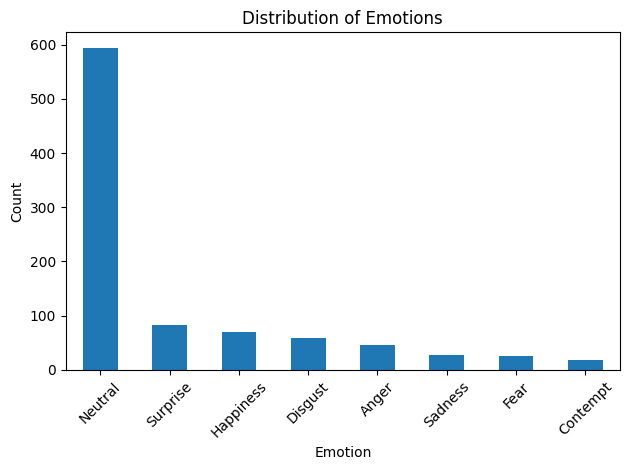

In [ ]:
# Map emotion values to their corresponding labels
emotion_labels = data["emotion"].map(EMOTION_MAPPING)

# Count the occurrences of each emotion
emotion_counts = emotion_labels.value_counts()

# Plotting the distribution
emotion_counts.plot(kind="bar")
plt.title("Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ablation Study

In [ ]:
from vit_pytorch.vit import ViT
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

BASE_PARAMETERS = {
  # Dataset-dependant parameters
  'image_size': 48,
  'channels': 1,
  'num_classes': 8,
  # Parameters we can play with
  'patch_size': 16,
  'dim': 512,
  'depth': 6,
  'heads': 16,
  'mlp_dim': 1024,
  'dropout': 0.1,
  'emb_dropout': 0.1,
}

def ablation_train(model_parameters, epochs=5, base_parameters=BASE_PARAMETERS):


  final_parameters = base_parameters.copy()
  final_parameters.update(model_parameters)

  net = ViT(**final_parameters).to(device)

  EPOCHS = 5
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  accuracies = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, quiet=True)
  test_accuracies = np.array(accuracies)[:, 1]
  max_accuracy = np.max(test_accuracies)

  del net

  return max_accuracy

In [ ]:
def run_ablation_study_single_parameter(ablation_parameters):
    results = {}

    for param, values in ablation_parameters.items():
        results[param] = {}
        for value in values:
            try:
                # Create a dictionary with the current parameter and value
                model_parameters = {param: value}
                # Run the ablation_train function with these parameters
                print(f'Training with {model_parameters}')
                max_accuracy = ablation_train(model_parameters)
            except Exception as e:
                # If an error occurs, set max_accuracy to 0
                max_accuracy = 0
                print(f"!!! Error with {param}={value}: {e} !!!")
            # Store the result
            results[param][value] = max_accuracy
            #print(results)

    return results

In [ ]:
ablation_parameters = {
    'patch_size': [4, 8, 16],
    'dim': [128, 256, 512, 1024],
    'depth': [4, 6, 8],
    'heads': [8, 12, 16, 20],
    'mlp_dim': [512, 1024, 2048],
    'dropout': [0.0, 0.1, 0.2],
    'emb_dropout': [0.0, 0.1, 0.2],
}

ablation_study_results = run_ablation_study_single_parameter(ablation_parameters)
print(ablation_study_results)

Training with {'patch_size': 4}
Training with {'patch_size': 8}
Training with {'patch_size': 16}
Training with {'dim': 128}
Training with {'dim': 256}
Training with {'dim': 512}
Training with {'dim': 1024}
Training with {'depth': 4}
Training with {'depth': 6}
Training with {'depth': 8}
Training with {'heads': 8}
Training with {'heads': 12}
Training with {'heads': 16}
Training with {'heads': 20}
Training with {'mlp_dim': 512}
Training with {'mlp_dim': 1024}
Training with {'mlp_dim': 2048}
Training with {'dropout': 0.0}
Training with {'dropout': 0.1}
Training with {'dropout': 0.2}
Training with {'emb_dropout': 0.0}
Training with {'emb_dropout': 0.1}
Training with {'emb_dropout': 0.2}
{'patch_size': {4: 0.6358695652173914, 8: 0.7989130434782609, 16: 0.7771739130434783}, 'dim': {128: 0.7717391304347826, 256: 0.7880434782608695, 512: 0.7934782608695652, 1024: 0.6793478260869565}, 'depth': {4: 0.7934782608695652, 6: 0.7989130434782609, 8: 0.7717391304347826}, 'heads': {8: 0.7880434782608695,

# Train

In [ ]:
# Original ViT
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from vit_pytorch.vit import ViT

accuracies = []
for fold_i, (trainloader, testloader) in enumerate(kf_loaders):
  print(f' ===== Fold {fold_i} =====')
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 8,
      dim = 512,
      depth = 6,
      heads = 12,
      mlp_dim = 512,
      dropout = 0.2,
      emb_dropout = 0.2,
      channels = 1
  ).to(device)

  EPOCHS = 30
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  fold_acc = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, output_file=f'vit-{fold_i}')
  print(fold_acc)
  accuracies.append(fold_acc)

print(accuracies)

 ===== Fold 0 =====
Epoch 1/30 - Current Learning Rate: 0.001000
[Epoch: 1, Batch: 1] loss: 0.354
[Epoch: 1, Batch: 3] loss: 0.304
[Epoch: 1, Batch: 5] loss: 0.277
[Epoch: 1, Batch: 7] loss: 0.255
[Epoch: 1, Batch: 9] loss: 0.290
[Epoch: 1, Batch: 11] loss: 0.263
Accuracy of the network on the test images: 60.87%
Epoch 2/30 - Current Learning Rate: 0.000997
[Epoch: 2, Batch: 1] loss: 0.129
[Epoch: 2, Batch: 3] loss: 0.231
[Epoch: 2, Batch: 5] loss: 0.236
[Epoch: 2, Batch: 7] loss: 0.221
[Epoch: 2, Batch: 9] loss: 0.199
[Epoch: 2, Batch: 11] loss: 0.157
Accuracy of the network on the test images: 78.26%
Epoch 3/30 - Current Learning Rate: 0.000989
[Epoch: 3, Batch: 1] loss: 0.101
[Epoch: 3, Batch: 3] loss: 0.171
[Epoch: 3, Batch: 5] loss: 0.174
[Epoch: 3, Batch: 7] loss: 0.151
[Epoch: 3, Batch: 9] loss: 0.136
[Epoch: 3, Batch: 11] loss: 0.154
Accuracy of the network on the test images: 76.63%
Epoch 4/30 - Current Learning Rate: 0.000976
[Epoch: 4, Batch: 1] loss: 0.057
[Epoch: 4, Batch:

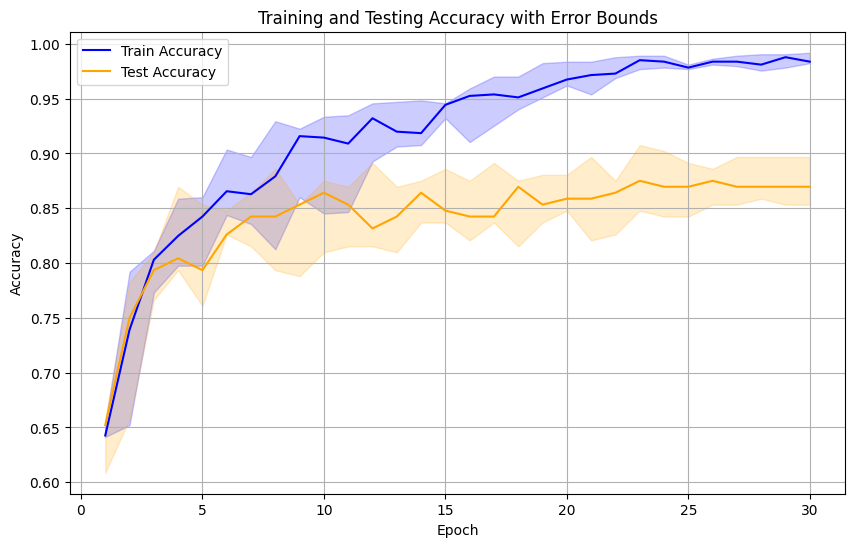

In [ ]:
from matplotlib import pyplot as plt

train_accuracies = np.array([[epoch[0] for epoch in model] for model in accuracies])
test_accuracies = np.array([[epoch[1] for epoch in model] for model in accuracies])


train_median = np.median(train_accuracies, axis=0)
train_min = np.min(train_accuracies, axis=0)
train_max = np.max(train_accuracies, axis=0)

test_median = np.median(test_accuracies, axis=0)
test_min = np.min(test_accuracies, axis=0)
test_max = np.max(test_accuracies, axis=0)


epochs = np.arange(1, len(train_median) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_median, label='Train Accuracy', color='blue')
plt.fill_between(epochs, train_min, train_max, color='blue', alpha=0.2)
plt.plot(epochs, test_median, label='Test Accuracy', color='orange')
plt.fill_between(epochs, test_min, test_max, color='orange', alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy with Error Bounds')
plt.legend()
plt.grid(True)
plt.show()


# Results Analysis

In [ ]:
!cp /content/vit-0_0.91.pth /content/vit-0.pth
!cp /content/vit-1_0.88.pth /content/vit-1.pth
!cp /content/vit-2_0.87.pth /content/vit-2.pth
!cp /content/vit-3_0.93.pth /content/vit-3.pth
!cp /content/vit-4_0.90.pth /content/vit-4.pth

In [ ]:
# Load models
import torch
from vit_pytorch.vit import ViT

nets = []
for i in range(5):
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 8,
      dim = 512,
      depth = 6,
      heads = 12,
      mlp_dim = 512,
      dropout = 0.2,
      emb_dropout = 0.2,
      channels = 1
  ).to(device)


  model_state_dict = torch.load(f'./vit-{i}.pth', map_location=torch.device(device))
  net.load_state_dict(model_state_dict)

  nets.append(net)

<ipython-input-40-dcedf782d891>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(f'./vit-{i}.pth', map_location=torch.device(device))


In [ ]:
data['prediction_correct'] = None
data['fold'] = None

for fold_idx, (train_idx, test_idx) in enumerate(kf_idx):
    if fold_idx >= len(nets):
        break
    print(f"Evaluating fold {fold_idx}")
    data.loc[test_idx, 'fold'] = fold_idx
    net = nets[fold_idx]
    net.eval()

    # Create the test DataLoader for the current fold
    test_dataset = FaceEmotionDataset(data.iloc[test_idx], transform=transform_test)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize a list to store the correctness of predictions
    results = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits)
            outputs = net(inputs)

            # Compute predicted class indices
            preds = torch.argmax(outputs, dim=1)

            # Get true class indices from one-hot encoded labels
            true_labels = torch.argmax(labels, dim=1)

            # Compare predictions with true labels
            corrects = preds.eq(true_labels).cpu().numpy()
            results.extend(corrects)

    # Store the results in the original dataframe
    for idx, correct in zip(test_idx, results):
        data.at[idx, 'prediction_correct'] = bool(correct)


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4


In [ ]:
def aggregate_error_by_column(column):
  percentage_error = (
    data[data['prediction_correct'] == False]
    .groupby(['fold', column])
    .size() / data.groupby(['fold', column]).size()
  ) * 100


  percentage_error = percentage_error.reset_index(name='percentage_incorrect')
  return percentage_error.groupby(column)['percentage_incorrect'].agg(['min', 'median', 'max'])


In [ ]:
data['emotion'] = data['emotion'].replace(EMOTION_MAPPING)

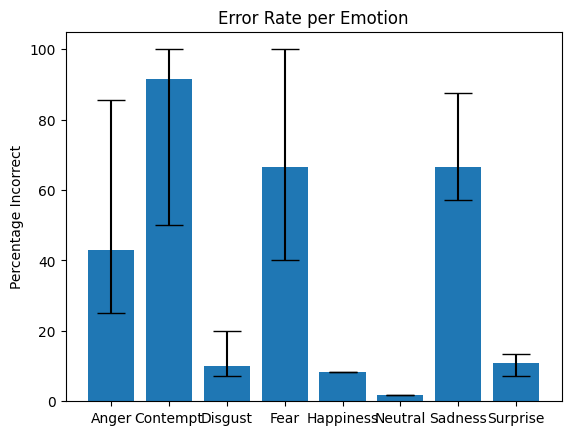

In [ ]:
from matplotlib import pyplot as plt

stats = aggregate_error_by_column('emotion')

plt.bar(stats.index, stats['median'], yerr=[stats['median'] - stats['min'], stats['max'] - stats['median']], capsize=10)
plt.ylabel('Percentage Incorrect')
plt.xticks(stats.index, stats.index)
plt.title('Error Rate per Emotion')
plt.show()

In [ ]:
data['emotion'].value_counts()

,count
emotion,
Neutral,593
Surprise,83
Happiness,69
Disgust,59
Anger,45
Sadness,28
Fear,25
Contempt,18


In [ ]:
stats

,min,median,max
emotion,,,
Anger,25.000000,42.857143,85.714286
Contempt,50.000000,91.666667,100.000000
Disgust,7.142857,10.000000,20.000000
Fear,40.000000,66.666667,100.000000
Happiness,8.333333,8.333333,8.333333
Neutral,1.652893,1.666667,1.785714
Sadness,57.142857,66.666667,87.500000
Surprise,7.142857,10.882353,13.333333


In [ ]:
value_count_error = pd.merge(data['emotion'].value_counts(), stats, on='emotion')

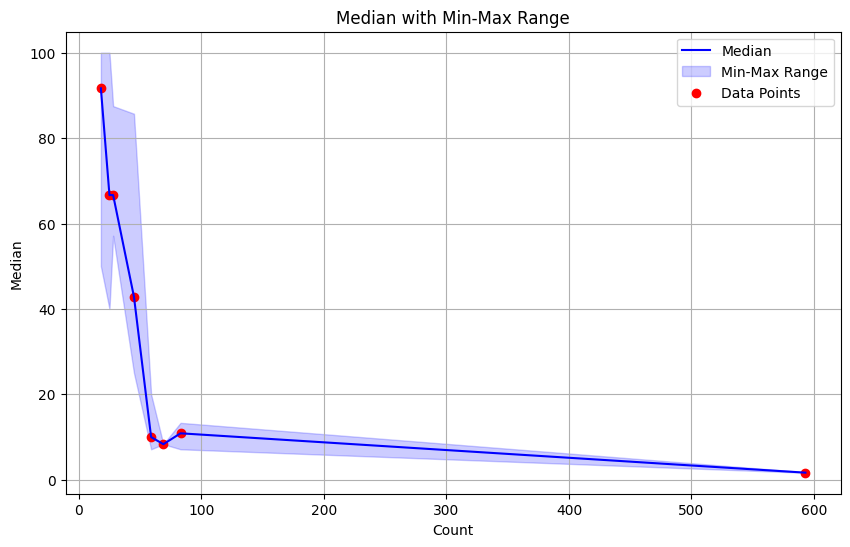

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(value_count_error['count'], value_count_error['median'], label='Median', color='blue')
plt.fill_between(value_count_error['count'], value_count_error['min'], value_count_error['max'], color='blue', alpha=0.2, label='Min-Max Range')
plt.scatter(value_count_error['count'], value_count_error['median'], color='red', label='Data Points')

# Add labels and legend
plt.xlabel('Count')
plt.ylabel('Median')
plt.title('Median with Min-Max Range')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Solution

In [ ]:
emotion_counts = data['emotion'].value_counts()

def assign_weight(count):
    if count < 50:
        return 2.0
    elif count > 100:
        return 0.25
    else:
        return 1.0

emotion_weights_df = emotion_counts.apply(assign_weight)


emotion_weights = torch.zeros(len(emotion_weights_df), device=device)
for idx, value in emotion_weights_df.items():
    emotion_weights[idx] = value
emotion_weights

tensor([2.0000, 1.0000, 2.0000, 1.0000, 2.0000, 1.0000, 0.2500, 2.0000],
       device='cuda:0')

In [ ]:
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from vit_pytorch.vit import ViT

nets = []
accuracies = []
for fold_i, (trainloader, testloader) in enumerate(kf_loaders):
  print(f' ===== Fold {fold_i} =====')
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 8,
      dim = 512,
      depth = 6,
      heads = 12,
      mlp_dim = 512,
      dropout = 0.2,
      emb_dropout = 0.2,
      channels = 1
  ).to(device)

  EPOCHS = 30
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss(pos_weight=emotion_weights)
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  fold_acc = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, output_file=f'vit-{fold_i}')
  print(fold_acc)
  accuracies.append(fold_acc)
  nets.append(net)

print(accuracies)

 ===== Fold 0 =====
Epoch 1/30 - Current Learning Rate: 0.001000
[Epoch: 1, Batch: 1] loss: 0.377
[Epoch: 1, Batch: 3] loss: 0.312
[Epoch: 1, Batch: 5] loss: 0.305
[Epoch: 1, Batch: 7] loss: 0.251
[Epoch: 1, Batch: 9] loss: 0.268
[Epoch: 1, Batch: 11] loss: 0.303
Accuracy of the network on the test images: 60.87%
Epoch 2/30 - Current Learning Rate: 0.000997
[Epoch: 2, Batch: 1] loss: 0.126
[Epoch: 2, Batch: 3] loss: 0.260
[Epoch: 2, Batch: 5] loss: 0.231
[Epoch: 2, Batch: 7] loss: 0.209
[Epoch: 2, Batch: 9] loss: 0.270
[Epoch: 2, Batch: 11] loss: 0.220
Accuracy of the network on the test images: 75.00%
Epoch 3/30 - Current Learning Rate: 0.000989
[Epoch: 3, Batch: 1] loss: 0.092
[Epoch: 3, Batch: 3] loss: 0.173
[Epoch: 3, Batch: 5] loss: 0.180
[Epoch: 3, Batch: 7] loss: 0.189
[Epoch: 3, Batch: 9] loss: 0.175
[Epoch: 3, Batch: 11] loss: 0.174
Accuracy of the network on the test images: 74.46%
Epoch 4/30 - Current Learning Rate: 0.000976
[Epoch: 4, Batch: 1] loss: 0.086
[Epoch: 4, Batch:

In [ ]:
data['prediction_correct'] = None
data['fold'] = None

for fold_idx, (train_idx, test_idx) in enumerate(kf_idx):
    if fold_idx >= len(nets):
        break
    print(f"Evaluating fold {fold_idx}")
    data.loc[test_idx, 'fold'] = fold_idx
    net = nets[fold_idx]
    net.eval()

    # Create the test DataLoader for the current fold
    test_dataset = FaceEmotionDataset(data.iloc[test_idx], transform=transform_test)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize a list to store the correctness of predictions
    results = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits)
            outputs = net(inputs)

            # Compute predicted class indices
            preds = torch.argmax(outputs, dim=1)

            # Get true class indices from one-hot encoded labels
            true_labels = torch.argmax(labels, dim=1)

            # Compare predictions with true labels
            corrects = preds.eq(true_labels).cpu().numpy()
            results.extend(corrects)

    # Store the results in the original dataframe
    for idx, correct in zip(test_idx, results):
        data.at[idx, 'prediction_correct'] = bool(correct)


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4


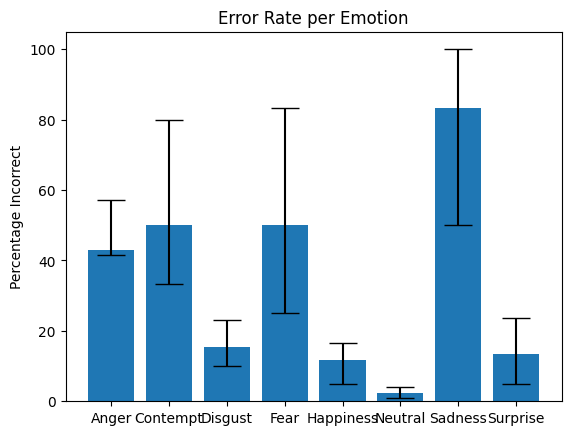

In [ ]:
def aggregate_error_by_column(column):
  percentage_error = (
    data[data['prediction_correct'] == False]
    .groupby(['fold', column])
    .size() / data.groupby(['fold', column]).size()
  ) * 100


  percentage_error = percentage_error.reset_index(name='percentage_incorrect')
  return percentage_error.groupby(column)['percentage_incorrect'].agg(['min', 'median', 'max'])


data['emotion_txt'] = data['emotion'].replace(EMOTION_MAPPING)

from matplotlib import pyplot as plt

stats = aggregate_error_by_column('emotion_txt')

plt.bar(stats.index, stats['median'], yerr=[stats['median'] - stats['min'], stats['max'] - stats['median']], capsize=10)
plt.ylabel('Percentage Incorrect')
plt.xticks(stats.index, stats.index)
plt.title('Error Rate per Emotion')
plt.show()

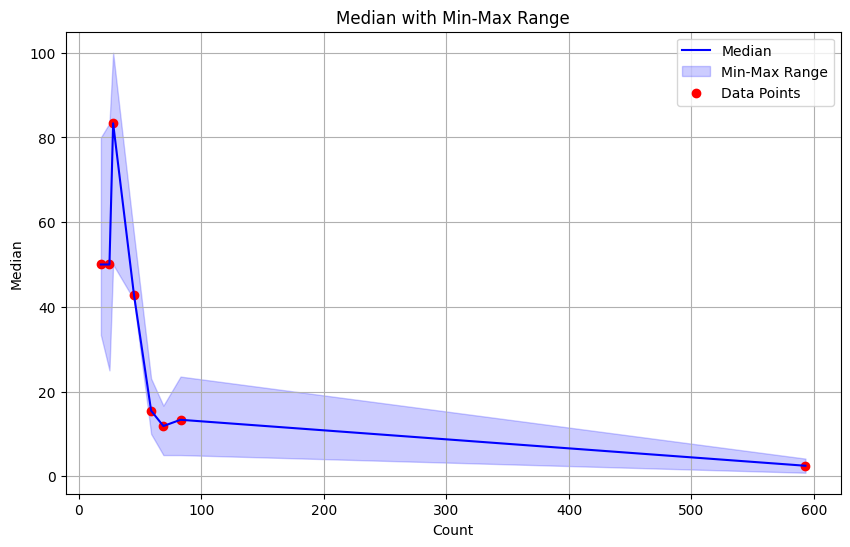

In [ ]:
value_count_error = pd.merge(data['emotion_txt'].value_counts(), stats, on='emotion_txt')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(value_count_error['count'], value_count_error['median'], label='Median', color='blue')
plt.fill_between(value_count_error['count'], value_count_error['min'], value_count_error['max'], color='blue', alpha=0.2, label='Min-Max Range')
plt.scatter(value_count_error['count'], value_count_error['median'], color='red', label='Data Points')

# Add labels and legend
plt.xlabel('Count')
plt.ylabel('Median')
plt.title('Median with Min-Max Range')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
data

,emotion,pixels,Usage,prediction_correct,fold,emotion_txt
0,6,"[36, 39, 35, 25, 19, 11, 8, 7, 3, 13, 15, 9, 2...",Training,True,3,Neutral
1,6,"[88, 74, 19, 4, 5, 5, 3, 12, 8, 21, 15, 21, 15...",Training,True,1,Neutral
2,6,"[9, 2, 4, 7, 1, 1, 1, 0, 7, 29, 49, 76, 115, 1...",Training,True,0,Neutral
3,6,"[104, 106, 108, 104, 95, 50, 60, 61, 58, 83, 1...",Training,True,2,Neutral
4,6,"[68, 72, 67, 67, 6, 2, 1, 1, 1, 1, 1, 14, 24, ...",Training,True,4,Neutral
...,...,...,...,...,...,...
915,5,"[87, 86, 88, 92, 92, 127, 231, 248, 251, 253, ...",PrivateTest,True,2,Surprise
916,5,"[21, 24, 26, 28, 27, 28, 30, 8, 0, 0, 0, 0, 0,...",PrivateTest,True,3,Surprise
917,5,"[76, 40, 31, 38, 28, 34, 38, 36, 41, 36, 46, 3...",PrivateTest,True,0,Surprise
918,5,"[114, 87, 16, 29, 17, 25, 30, 34, 37, 35, 45, ...",PrivateTest,True,4,Surprise


In [ ]:
from torch.utils.data import WeightedRandomSampler

def generate_sampler_for_fold(fold_df):
  labels = fold_df['emotion'].values

  class_counts = torch.bincount(torch.tensor(labels, dtype=torch.long))
  class_weights = 1.0 / class_counts.float()

  # Map class weights to individual sample weights
  sample_weights = torch.tensor([class_weights[label] for label in labels], dtype=torch.float)

  # Create a WeightedRandomSampler
  sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

  return sampler

kf_loaders_weighted = [
    (DataLoader(FaceEmotionDataset(data.iloc[train_idx], transform=transform_train), batch_size=BATCH_SIZE, sampler=generate_sampler_for_fold(data.iloc[train_idx]), num_workers=2),
    DataLoader(FaceEmotionDataset(data.iloc[test_idx], transform=transform_test), batch_size=64, shuffle=False, num_workers=2))
    for (train_idx, test_idx) in kf_idx
]


import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from vit_pytorch.vit import ViT

nets = []
accuracies = []
for fold_i, (trainloader, testloader) in enumerate(kf_loaders_weighted):
  print(f' ===== Fold {fold_i} =====')
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 8,
      dim = 512,
      depth = 6,
      heads = 12,
      mlp_dim = 512,
      dropout = 0.2,
      emb_dropout = 0.2,
      channels = 1
  ).to(device)

  EPOCHS = 30
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  fold_acc = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, output_file=f'vit-{fold_i}')
  print(fold_acc)
  accuracies.append(fold_acc)
  nets.append(net)

print(accuracies)

 ===== Fold 0 =====
Epoch 1/30 - Current Learning Rate: 0.001000
[Epoch: 1, Batch: 1] loss: 0.380
[Epoch: 1, Batch: 3] loss: 0.458
[Epoch: 1, Batch: 5] loss: 0.407
[Epoch: 1, Batch: 7] loss: 0.452
[Epoch: 1, Batch: 9] loss: 0.403
[Epoch: 1, Batch: 11] loss: 0.375
Accuracy of the network on the test images: 6.52%
Epoch 2/30 - Current Learning Rate: 0.000997
[Epoch: 2, Batch: 1] loss: 0.185
[Epoch: 2, Batch: 3] loss: 0.342
[Epoch: 2, Batch: 5] loss: 0.298
[Epoch: 2, Batch: 7] loss: 0.291
[Epoch: 2, Batch: 9] loss: 0.258
[Epoch: 2, Batch: 11] loss: 0.263
Accuracy of the network on the test images: 42.93%
Epoch 3/30 - Current Learning Rate: 0.000989
[Epoch: 3, Batch: 1] loss: 0.121
[Epoch: 3, Batch: 3] loss: 0.197
[Epoch: 3, Batch: 5] loss: 0.193
[Epoch: 3, Batch: 7] loss: 0.180
[Epoch: 3, Batch: 9] loss: 0.170
[Epoch: 3, Batch: 11] loss: 0.183
Accuracy of the network on the test images: 75.54%
Epoch 4/30 - Current Learning Rate: 0.000976
[Epoch: 4, Batch: 1] loss: 0.082
[Epoch: 4, Batch: 

In [ ]:
data['prediction_correct'] = None
data['fold'] = None

for fold_idx, (train_idx, test_idx) in enumerate(kf_idx):
    if fold_idx >= len(nets):
        break
    print(f"Evaluating fold {fold_idx}")
    data.loc[test_idx, 'fold'] = fold_idx
    net = nets[fold_idx]
    net.eval()

    # Create the test DataLoader for the current fold
    test_dataset = FaceEmotionDataset(data.iloc[test_idx], transform=transform_test)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize a list to store the correctness of predictions
    results = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits)
            outputs = net(inputs)

            # Compute predicted class indices
            preds = torch.argmax(outputs, dim=1)

            # Get true class indices from one-hot encoded labels
            true_labels = torch.argmax(labels, dim=1)

            # Compare predictions with true labels
            corrects = preds.eq(true_labels).cpu().numpy()
            results.extend(corrects)

    # Store the results in the original dataframe
    for idx, correct in zip(test_idx, results):
        data.at[idx, 'prediction_correct'] = bool(correct)


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4


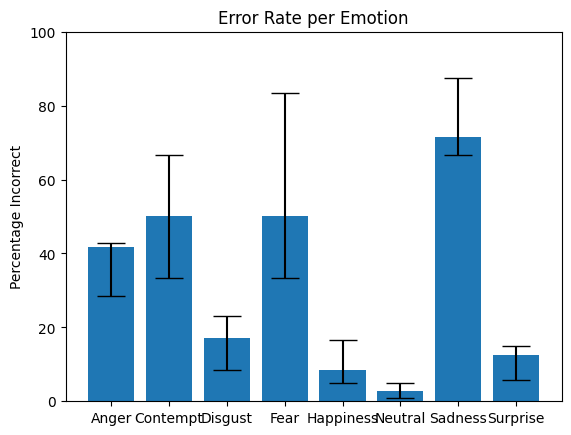

In [ ]:
def aggregate_error_by_column(column):
  percentage_error = (
    data[data['prediction_correct'] == False]
    .groupby(['fold', column])
    .size() / data.groupby(['fold', column]).size()
  ) * 100


  percentage_error = percentage_error.reset_index(name='percentage_incorrect')
  return percentage_error.groupby(column)['percentage_incorrect'].agg(['min', 'median', 'max'])


data['emotion_txt'] = data['emotion'].replace(EMOTION_MAPPING)

from matplotlib import pyplot as plt

stats = aggregate_error_by_column('emotion_txt')

plt.bar(stats.index, stats['median'], yerr=[stats['median'] - stats['min'], stats['max'] - stats['median']], capsize=10)
plt.ylabel('Percentage Incorrect')
plt.xticks(stats.index, stats.index)
plt.title('Error Rate per Emotion')
plt.ylim(top=100)
plt.show()

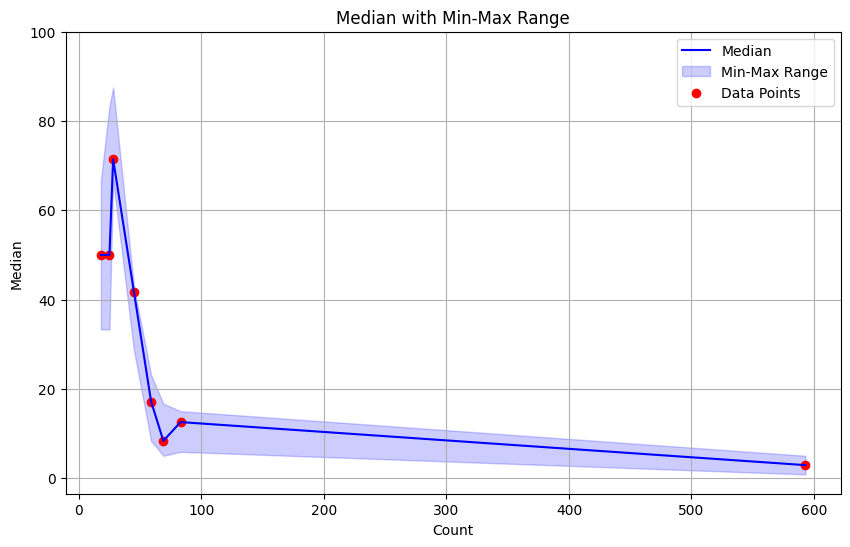

In [ ]:
value_count_error = pd.merge(data['emotion_txt'].value_counts(), stats, on='emotion_txt')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(value_count_error['count'], value_count_error['median'], label='Median', color='blue')
plt.fill_between(value_count_error['count'], value_count_error['min'], value_count_error['max'], color='blue', alpha=0.2, label='Min-Max Range')
plt.scatter(value_count_error['count'], value_count_error['median'], color='red', label='Data Points')

# Add labels and legend
plt.xlabel('Count')
plt.ylabel('Median')
plt.title('Median with Min-Max Range')
plt.legend()
plt.grid(True)
plt.ylim(top=100)


# Show the plot
plt.show()